# Crypto Portfolio Backtesting System with Nautilus Trader

This notebook establishes a foundational system for backtesting and comparing different portfolio management strategies for cryptocurrencies using the `nautilus-trader` framework.

We will implement and compare two fundamental strategies:
1.  **Hodler Strategy**: Buys and holds BTC and ETH in equal dollar amounts at the start of the backtest.
2.  **Index Rebalance Strategy**: Buys BTC and ETH and periodically rebalances the portfolio to maintain a fixed 50/50 weight.

We will use 1-hour bar data for `BTC/USDT` and `ETH/USDT`.

In [1]:
# !pip install nautilus_trader pyarrow pandas matplotlib numpy

## 1. Imports and Setup

First, we import all the necessary components from `nautilus-trader` and other libraries for data handling and plotting. We'll also set up our logging and data directory.

In [2]:
import os
import shutil
import zipfile
from decimal import Decimal
from datetime import datetime, timedelta
import glob

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Core Nautilus Trader components
from nautilus_trader.backtest.node import BacktestNode
from nautilus_trader.config import BacktestRunConfig, BacktestVenueConfig, BacktestDataConfig, StrategyConfig
from nautilus_trader.core.datetime import dt_to_unix_nanos
from nautilus_trader.model.data import Bar, BarType, BarSpecification
from nautilus_trader.model.enums import AccountType, OrderSide, OrderType, PositionSide, TimeInForce
from nautilus_trader.model.events import OrderFilled
from nautilus_trader.model.identifiers import InstrumentId, StrategyId, Venue, Symbol
from nautilus_trader.model.objects import Money, Price, Quantity, Currency
from nautilus_trader.model.orders import MarketOrder, Order
from nautilus_trader.model.position import Position
from nautilus_trader.persistence.catalog import ParquetDataCatalog
from nautilus_trader.trading.strategy import Strategy
from nautilus_trader.adapters.binance import BinanceBar
from nautilus_trader.persistence.catalog import ParquetDataCatalog
from nautilus_trader.model.instruments import CurrencyPair, Instrument
# Set up logging to see the output from the backtest engine
from nautilus_trader.common.component import Logger

# Create a directory for our backtest data
CATALOG_PATH = os.path.expanduser("~/backtest_jup/data/catalog")
DATA_DIR = os.path.expanduser("~/backtest_jup/data")
if os.path.exists(CATALOG_PATH):
    shutil.rmtree(CATALOG_PATH)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(CATALOG_PATH, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Data catalog path: {CATALOG_PATH}")

Data directory: /Users/yb/backtest_jup/data
Data catalog path: /Users/yb/backtest_jup/data/catalog


## 2. Data Preparation

We will now process historical 1-hour bar data from CSV files downloaded from the [Binance Public Data](https://github.com/binance/binance-public-data/) repository.

The function below is tailored to read these specific CSVs, which have no headers and a fixed column structure. To make this notebook runnable, we will first generate some sample CSV files in the expected format.

In [3]:
def make_binance_bars_from_csv(file_path, instrument_id, price_precision, size_precision):
    columns = [
        'open_time', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ]
    df = pd.read_csv(file_path, header=None, names=columns)

    # dynamic assign 'us' or 'ms' based on opentime digits   
    if len(str(df['open_time'][0])) == 13:
        unit = 'ms'
    else:
        unit = 'us'
    df['timestamp'] = pd.to_datetime(df['open_time'], unit=unit)

    bars = []
    for _, row in df.iterrows():
        bars.append(
            BinanceBar(
                bar_type=BarType.from_str(f"{instrument_id}-1-HOUR-LAST-EXTERNAL"),
                open=Price(float(row['open']), price_precision),
                high=Price(float(row['high']), price_precision),
                low=Price(float(row['low']), price_precision),
                close=Price(float(row['close']), price_precision),
                volume=Quantity(float(row['volume']), size_precision),
                quote_volume=Quantity(float(row['quote_asset_volume']), size_precision),
                taker_buy_base_volume=Quantity(float(row['taker_buy_base_asset_volume']), size_precision),
                taker_buy_quote_volume=Quantity(float(row['taker_buy_quote_asset_volume']), size_precision),
                count=int(row['number_of_trades']),
                ts_event=dt_to_unix_nanos(row['timestamp']),
                ts_init=dt_to_unix_nanos(row['timestamp']),
            )
        )
    return bars


## 3. Define Trading Instruments

We need to define the `Instrument` objects for the assets we want to trade. This includes information like the asset pair, venue, price precision, and quantity precision.

In [4]:

# Configure a simulated venue with a simple percentage-based commission
venue_config = BacktestVenueConfig(
    name="BINANCE",
    oms_type="HEDGING", # Use HEDGING for simple portfolio management
    account_type=AccountType.CASH,
    base_currency=Currency.from_str("USDT"),
    starting_balances=[Money(10_000, Currency.from_str("USDT"))],
    # Apply a 0.1% taker fee to simulate exchange costs
    maker_fee_rate=Decimal("0.001"), 
    taker_fee_rate=Decimal("0.001"), 
)

def make_crypto_instrument(symbol: str, price_precision: int, size_precision: int) -> CurrencyPair:
    """Helper function to create a crypto instrument."""
    base, quote = symbol.split("-")
    return CurrencyPair(
            instrument_id=InstrumentId(
                symbol=Symbol(f"{base}{quote}"),
                venue=Venue("BINANCE"),
            ),
            raw_symbol=Symbol(f"{base}{quote}"),
            base_currency=Currency.from_str(base),
            quote_currency=Currency.from_str(quote),
            price_precision=price_precision,
            size_precision=size_precision,
            price_increment=Price(1e-02, precision=price_precision),
            size_increment=Quantity(1e-06, precision=size_precision),
            lot_size=None,
            max_quantity=Quantity(9000, precision=size_precision),
            min_quantity=Quantity(1e-06, precision=size_precision),
            max_notional=None,
            min_notional=Money(10.00000000, Currency.from_str(quote)),
            max_price=Price(1000000, precision=price_precision),
            min_price=Price(0.01, precision=price_precision),
            margin_init=Decimal(0),
            margin_maint=Decimal(0),
            maker_fee=Decimal("0.001"),
            taker_fee=Decimal("0.001"),
            ts_event=0,
            ts_init=0,
        )


# instruments = make_crypto_instrument("BTC-USDT", price_precision=2, size_precision=6),


TypeError: Unexpected keyword argument 'maker_fee_rate'

## 4. Implement Trading Strategies

Here we define the logic for our two strategies.

### Hodler Strategy

This is the simplest strategy. It allocates a portion of the starting capital to each asset, buys them on the first data tick (bar), and then holds them for the entire duration of the backtest.

### Time-based Index Rebalance Strategy

This strategy also starts by buying the assets, but it includes logic to periodically rebalance the portfolio to maintain a target weight for each asset. We'll set a rebalance interval (e.g., every 7 days) and on that schedule, the strategy will adjust the holdings by buying or selling.

**Key Features:**
- **Time-based rebalancing**: Rebalances at regular intervals (e.g., every 7, 14, or 30 days)
- **Multi-asset support**: Can handle any number of assets with custom target weights
- **Flexible intervals**: You can set different rebalancing periods
- **Predictable**: Rebalancing happens on a schedule, making it easy to plan

**Example Usage:**

```python
# For a 60/40 BTC/ETH portfolio with weekly rebalancing
btc_eth_weights = {
    btc_instrument.id: 0.6,  # 60% BTC
    eth_instrument.id: 0.4   # 40% ETH
}

time_config = TimebasedIndexRebalanceConfig(
    instrument_id=btc_instrument.id,  # Primary instrument for bar subscription
    bar_type=BarType.from_str(f"{btc_instrument.id}-1-HOUR-LAST-EXTERNAL"),
    rebalance_period_days=7  # Rebalance every 7 days
)

time_rebalancer = TimebasedIndexRebalance(time_config, target_weights=btc_eth_weights)
```

### Ratio-Based Index Rebalance Strategy

This strategy triggers rebalancing when the portfolio weights deviate from target weights by a specified threshold. For example, if you have a 50/50 BTC/ETH portfolio with a 5% threshold, rebalancing will be triggered when the weights become 55/45 or 45/55.

**Key Features:**
- **Threshold-based rebalancing**: Only rebalances when deviation exceeds the specified threshold
- **Multi-asset support**: Can handle any number of assets with custom target weights
- **Flexible thresholds**: You can set different thresholds (e.g., 0.05 for 5% deviation)
- **Efficient**: Only trades when necessary, reducing transaction costs

**Example Usage:**

```python
# For a 50/50 BTC/ETH portfolio with 5% rebalancing threshold
btc_eth_weights = {
    btc_instrument.id: 0.5,  # 50% BTC
    eth_instrument.id: 0.5   # 50% ETH
}

ratio_config = RatioBasedIndexRebalanceConfig(
    instrument_id=btc_instrument.id,  # Primary instrument for bar subscription
    bar_type=BarType.from_str(f"{btc_instrument.id}-1-HOUR-LAST-EXTERNAL"),
    rebalance_threshold=0.05  # 5% deviation threshold
)

ratio_rebalancer = RatioBasedIndexRebalance(ratio_config, target_weights=btc_eth_weights)
```


## 5. Configure and Run the Backtest

Now we put everything together. We'll create instances of our strategies and configure the `BacktestNode` to run them simultaneously. This allows for a direct, side-by-side comparison.

Loaded 5088 bars for backtesting

--- Setting up Hodler Strategy ---
✅ Hodler strategy configured

--- Setting up TimeRebalance Strategy ---
✅ TimeRebalance strategy configured

--- Setting up RatioRebalance Strategy ---
2025-07-05T13:12:36.993720000Z [INFO] HODLER-ENGINE.BacktestEngine: =================================================================
2025-07-05T13:12:36.993728000Z [INFO] HODLER-ENGINE.BacktestEngine:  NAUTILUS TRADER - Automated Algorithmic Trading Platform
2025-07-05T13:12:36.993728001Z [INFO] HODLER-ENGINE.BacktestEngine:  by Nautech Systems Pty Ltd.
2025-07-05T13:12:36.993728002Z [INFO] HODLER-ENGINE.BacktestEngine:  Copyright (C) 2015-2025. All rights reserved.
2025-07-05T13:12:36.993728003Z [INFO] HODLER-ENGINE.BacktestEngine: =================================================================
2025-07-05T13:12:36.993729000Z [INFO] HODLER-ENGINE.BacktestEngine: 
2025-07-05T13:12:36.993729001Z [INFO] HODLER-ENGINE.BacktestEngine: ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣴⣶⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
2025

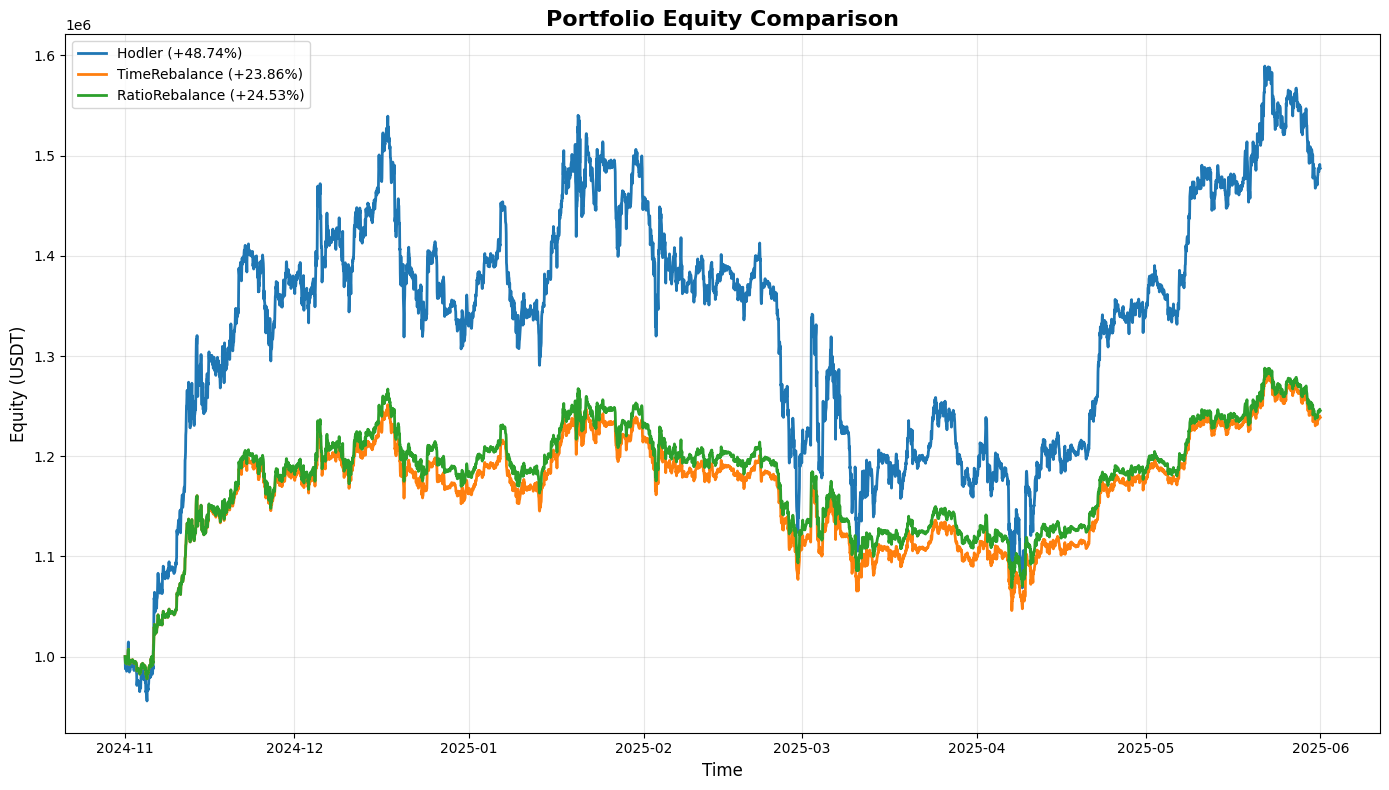


--- Cleanup ---
🧹 Hodler engine disposed
🧹 TimeRebalance engine disposed
🧹 RatioRebalance engine disposed
2025-07-05T13:12:37.867689000Z [INFO] HODLER-ENGINE.DataClient-BINANCE: READY
2025-07-05T13:12:37.867705000Z [INFO] HODLER-ENGINE.DataEngine: READY
2025-07-05T13:12:37.867715000Z [INFO] HODLER-ENGINE.ExecClient-BINANCE: READY
2025-07-05T13:12:37.867776000Z [INFO] HODLER-ENGINE.Cache: Reset
2025-07-05T13:12:37.867781000Z [INFO] HODLER-ENGINE.ExecEngine: READY
2025-07-05T13:12:37.867792000Z [INFO] HODLER-ENGINE.RiskEngine: READY
2025-07-05T13:12:37.867801000Z [INFO] HODLER-ENGINE.OrderEmulator: READY
2025-07-05T13:12:37.867814000Z [WARN] HODLER-ENGINE.Hodler: The `Strategy.on_reset` handler was called when not overridden. It's expected that any actions required when resetting the strategy occur here, such as resetting indicators and other state
2025-07-05T13:12:37.867816000Z [INFO] HODLER-ENGINE.Hodler: READY
2025-07-05T13:12:37.867930000Z [INFO] HODLER-ENGINE.Portfolio: READY
2025-

In [ ]:
from nautilus_trader.backtest.node import BacktestNode
from nautilus_trader.backtest.config import BacktestEngineConfig, BacktestRunConfig
from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.model import TraderId
from nautilus_trader.model.currencies import USDT
from nautilus_trader.model.enums import OmsType
from nautilus_trader.adapters.binance import BINANCE_VENUE
from nautilus_trader.model.enums import BookType
from nautilus_trader.model.instruments import CurrencyPair
from nautilus_trader.model.data import BarType
import matplotlib.pyplot as plt
import pandas as pd
from holder import Hodler, HodlerConfig
from timebased_rebalance import TimebasedIndexRebalance, TimebasedIndexRebalanceConfig
from ratiobased_rebalance import RatioBasedIndexRebalance, RatioBasedIndexRebalanceConfig


def create_backtest_engine(trader_id: str, starting_balance: float = 1_000_000.0):
    """Create a standardized backtest engine with common settings."""
    config = BacktestEngineConfig(trader_id=TraderId(trader_id))
    engine = BacktestEngine(config=config)
    
    # Add venue with standard settings
    engine.add_venue(
        venue=BINANCE_VENUE,
        oms_type=OmsType.NETTING,
        account_type=AccountType.CASH,
        base_currency=None,
        starting_balances=[Money(starting_balance, USDT)],
        bar_adaptive_high_low_ordering=True
    )
    return engine

def load_market_data():
    """Load and prepare market data for backtesting."""
    instrument_settings = {
        "ETHUSDT": {
            "instrument_id": "ETHUSDT.BINANCE",
            "price_precision": 2,
            "size_precision": 6,
        },
        "BTCUSDT": {
            "instrument_id": "BTCUSDT.BINANCE",
            "price_precision": 2,
            "size_precision": 6,
        },
    }
    
    # Create instruments
    instruments = make_crypto_instrument(
        "ETH-USDT", 
        price_precision=instrument_settings["ETHUSDT"]["price_precision"],
        size_precision=instrument_settings["ETHUSDT"]["size_precision"]
    )
    # Create instruments
    instruments = make_crypto_instrument(
        "BTC-USDT", 
        price_precision=instrument_settings["BTCUSDT"]["price_precision"],
        size_precision=instrument_settings["BTCUSDT"]["size_precision"]
    )


    # Load bar data
    all_bars = []
    for symbol, settings in instrument_settings.items():
        pattern = os.path.expanduser(f"~/backtest_jup/data/{symbol}-1h-*.csv")
        for file_path in glob.glob(pattern):
            bars = make_binance_bars_from_csv(
                file_path=file_path,
                instrument_id=settings["instrument_id"],
                price_precision=settings["price_precision"],
                size_precision=settings["size_precision"],
            )
            all_bars.extend(bars)
    
    return instruments, all_bars

def run_strategy_comparison():
    """Run multiple strategies and compare their performance."""
    
    # Load common data
    instruments, all_bars = load_market_data()
    print(f"Loaded {len(all_bars)} bars for backtesting")
    
    # Strategy configurations
    strategies_config = {
        "Hodler": {
            "engine_id": "HODLER-ENGINE",
            "strategy_class": Hodler,
            "config_class": HodlerConfig,
            "params": {},
            "weights": {instruments.id: 0.5}  # 50% ETH, 50% USDT
        },
        "TimeRebalance": {
            "engine_id": "TIME-REBALANCE-ENGINE", 
            "strategy_class": TimebasedIndexRebalance,
            "config_class": TimebasedIndexRebalanceConfig,
            "params": {"rebalance_period_days": 14},
            "weights": {instruments.id: 0.5}  # 50% ETH, 50% USDT
        },
        "RatioRebalance": {
            "engine_id": "RATIO-REBALANCE-ENGINE",
            "strategy_class": RatioBasedIndexRebalance,
            "config_class": RatioBasedIndexRebalanceConfig,
            "params": {"rebalance_threshold": 0.1},  # 10% deviation threshold
            "weights": {instruments.id: 0.5}  # 50% ETH, 50% USDT
        }
    }
    
    # Storage for results
    strategy_results = {}
    engines = {}
    
    # Create and configure each strategy
    for strategy_name, config in strategies_config.items():
        print(f"\n--- Setting up {strategy_name} Strategy ---")
        
        # Create engine
        engine = create_backtest_engine(config["engine_id"])
        engine.add_instrument(instruments)
        engine.add_data(all_bars)
        
        # Create strategy configuration
        strategy_config = config["config_class"](
            instrument_id=instruments.id,
            bar_type=BarType.from_str(f"{instruments.id}-1-HOUR-LAST-EXTERNAL"),
            **config["params"]
        )
        if "weights" in config:
            strategy = config["strategy_class"](strategy_config, target_weights=config["weights"])  # 50% ETH, 50% USDT
        else:
            strategy = config["strategy_class"](strategy_config)
        
        # Create strategy instance
        # Add strategy to engine
        engine.add_strategy(strategy=strategy)
        
        # Store for execution
        engines[strategy_name] = engine
        strategy_results[strategy_name] = strategy
        
        print(f"✅ {strategy_name} strategy configured")
    
    # Run all strategies
    print(f"\n--- Running {len(strategies_config)} Strategies ---")
    for strategy_name, engine in engines.items():
        print(f"🚀 Running {strategy_name}...")
        engine.run()
        print(f"✅ {strategy_name} completed")
    
    # Collect and plot results
    print(f"\n--- Analyzing Results ---")
    plot_strategy_comparison(strategy_results)
    
    # Cleanup
    print(f"\n--- Cleanup ---")
    for strategy_name, engine in engines.items():
        engine.reset()
        engine.dispose()
        print(f"🧹 {strategy_name} engine disposed")
    
    return strategy_results

def plot_strategy_comparison(strategy_results):
    """Plot equity curves for all strategies."""
    plt.figure(figsize=(14, 8))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (strategy_name, strategy) in enumerate(strategy_results.items()):
        if hasattr(strategy, 'equity_history') and strategy.equity_history:
            # Convert to DataFrame
            df = pd.DataFrame(strategy.equity_history, columns=["timestamp", "equity"])
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ns")
            
            # Calculate performance metrics
            initial_equity = df["equity"].iloc[0]
            final_equity = df["equity"].iloc[-1]
            total_return = (final_equity - initial_equity) / initial_equity * 100
            
            # Plot
            plt.plot(
                df["timestamp"], 
                df["equity"], 
                label=f"{strategy_name} ({total_return:+.2f}%)",
                color=colors[i % len(colors)],
                linewidth=2
            )
            
            print(f"📊 {strategy_name}: {initial_equity:,.0f} → {final_equity:,.0f} USDT ({total_return:+.2f}%)")
        else:
            print(f"⚠️  No equity history available for {strategy_name}")
    
    plt.title("Portfolio Equity Comparison", fontsize=16, fontweight='bold')
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Equity (USDT)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the comparison
strategy_results = run_strategy_comparison()